In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import resample
import sqlite3


In [9]:
# Load and combine CSV files from 2000 to 2004
def merged(years=range(2000, 2005)):
    df = pd.DataFrame()
    for year in years:
        file_name = f"{year}.csv.bz2"
        add = pd.read_csv(file_name, encoding='ISO-8859-1', nrows=10000)  
        df = pd.concat([df, add], ignore_index=True)
    return df

ontime = merged()


In [10]:
# Connect to SQLite database
conn = sqlite3.connect("airline2_r.db")

# Load data into SQLite database (change file paths accordingly)
airports = pd.read_csv("airports.csv")
carriers = pd.read_csv("carriers.csv")
planes = pd.read_csv("plane-data.csv")

# Insert data into the database tables
airports.to_sql("Airports", conn, if_exists="replace", index=False)
carriers.to_sql("Carriers", conn, if_exists="replace", index=False)
planes.to_sql("Planes", conn, if_exists="replace", index=False)

# Close the connection when done
conn.close()


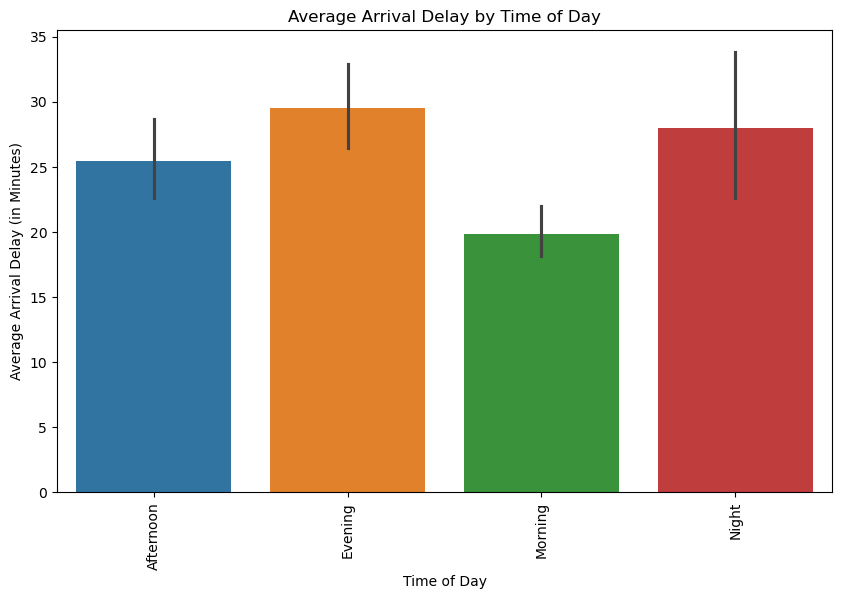

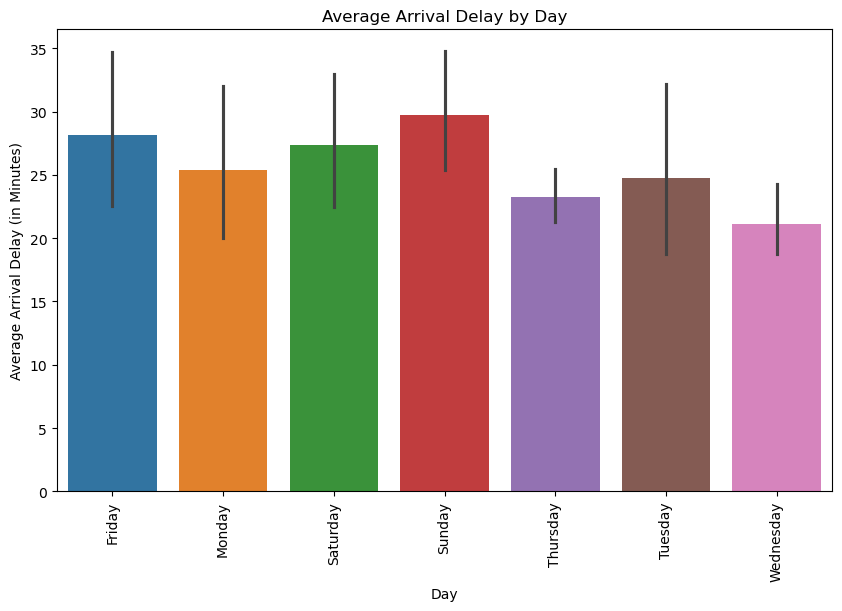

In [11]:
# Create 'TimeOfDay' based on CRSDepTime
def find_time(CRSDepTime):
    if 500 <= CRSDepTime <= 1159:
        return "Morning"
    elif 1200 <= CRSDepTime <= 1659:
        return "Afternoon"
    elif 1700 <= CRSDepTime <= 2059:
        return "Evening"
    else:
        return "Night"

ontime['TimeofDay'] = ontime['CRSDepTime'].apply(find_time)

# Create 'Day' based on DayOfWeek
def find_day(DayOfWeek):
    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    return days[DayOfWeek-1]

ontime['Day'] = ontime['DayOfWeek'].apply(find_day)

# Filter out negative ArrDelay values
ontime = ontime[ontime['ArrDelay'] > 0]

# Group by Year, Day, and Time of Day and calculate average delay
Delays = ontime.groupby(['Year', 'Day', 'TimeofDay'])['ArrDelay'].mean().reset_index()
Delays_clean = Delays.dropna()

# Plot average delay against Time of Day
plt.figure(figsize=(10,6))
sns.barplot(x='TimeofDay', y='ArrDelay', data=Delays_clean, hue='TimeofDay')
plt.xticks(rotation=90)
plt.title('Average Arrival Delay by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Average Arrival Delay (in Minutes)')
plt.show()

# Plot average delay against Day
plt.figure(figsize=(10,6))
sns.barplot(x='Day', y='ArrDelay', data=Delays_clean, hue='Day')
plt.xticks(rotation=90)
plt.title('Average Arrival Delay by Day')
plt.xlabel('Day')
plt.ylabel('Average Arrival Delay (in Minutes)')
plt.show()


Year 2000: Data after merging - 836745 rows.
Year 2000: Grouped data has 20 rows.
Year 2001: Data after merging - 87685 rows.
Year 2001: Grouped data has 11 rows.
Year 2002: Data after merging - 655494 rows.
Year 2002: Grouped data has 22 rows.
Year 2003: Data after merging - 1202111 rows.
Year 2003: Grouped data has 23 rows.
Year 2004: Data after merging - 1830517 rows.
Year 2004: Grouped data has 24 rows.


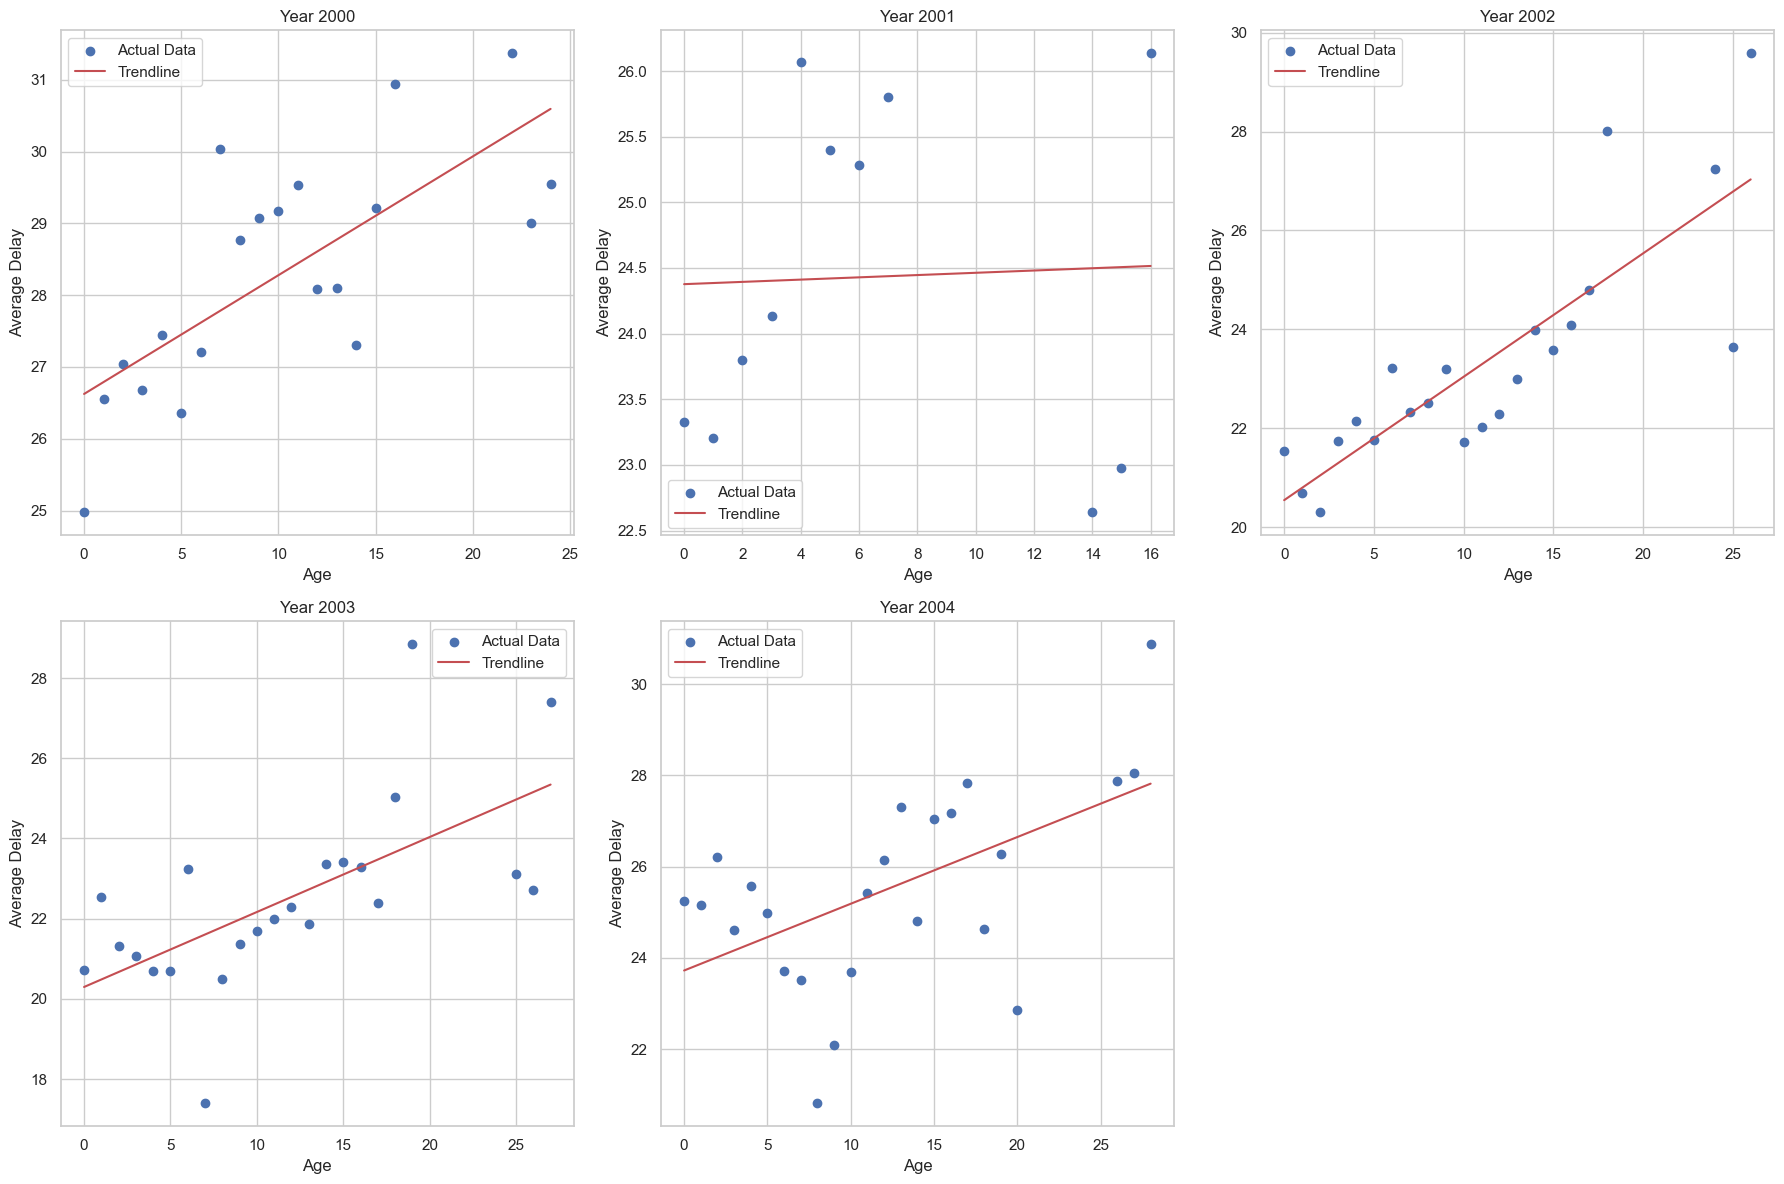

A correlation coefficient of 0.7302612946369358 indicates a moderate positive correlation between age of the aircraft and average arrival delays. Hence, this shows that there are more delays as the plane gets older in year 2000.
A correlation coefficient of 0.0375782627472627 indicates a weak positive correlation between age of the aircraft and average arrival delays. Hence, this shows that delays remain relatively consistent even as the plane gets older in year 2001.
A correlation coefficient of 0.8267295690896639 indicates a moderate positive correlation between age of the aircraft and average arrival delays. Hence, this shows that there are more delays as the plane gets older in year 2002.
A correlation coefficient of 0.6342423932581269 indicates a moderate positive correlation between age of the aircraft and average arrival delays. Hence, this shows that there are more delays as the plane gets older in year 2003.
A correlation coefficient of 0.5455586359652859 indicates a moderate 

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import scipy.stats
import seaborn as sns

# Create a list containing every year
years = list(range(2000, 2005))

# Initialize an empty list to store plots and correlation results for part 2(b)
correlation_results = []

# Load the planes data only once
planes = pd.read_csv("plane-data.csv")

# Function to plot the data and fit a linear regression trendline
def plot_and_analyze(grouped, year, ax):
    ax.scatter(grouped['plane_age'], grouped['average_delay'], marker='o', color='b', label='Actual Data')

    # Perform linear regression
    X = grouped[['plane_age']]
    y = grouped['average_delay']
    model = LinearRegression().fit(X, y)
    trendline = model.predict(X)

    # Plot the trendline
    ax.plot(grouped['plane_age'], trendline, color='r', label='Trendline')
    ax.set_title(f'Year {year}')
    ax.set_xlabel('Age')
    ax.set_ylabel('Average Delay')
    ax.legend()
    ax.grid(True)

# Function to interpret correlation results
def interpret_correlation(correlation, year):
    if 0.87 < correlation <= 1:
        return f"A correlation coefficient of {correlation} indicates a strong positive correlation between age of the aircraft and average arrival delays. Hence, this shows that there are significantly more delays as the plane gets older in year {year}."
    elif 0.5 < correlation <= 0.87:
        return f"A correlation coefficient of {correlation} indicates a moderate positive correlation between age of the aircraft and average arrival delays. Hence, this shows that there are more delays as the plane gets older in year {year}."
    elif 0 < correlation <= 0.5:
        return f"A correlation coefficient of {correlation} indicates a weak positive correlation between age of the aircraft and average arrival delays. Hence, this shows that delays remain relatively consistent even as the plane gets older in year {year}."
    elif -0.5 < correlation <= 0:
        return f"A correlation coefficient of {correlation} indicates a weak negative correlation between age of the aircraft and average arrival delays. Hence, this shows that delays remain relatively consistent even as the plane gets older in year {year}."
    elif -0.87 < correlation <= -0.5:
        return f"A correlation coefficient of {correlation} indicates a moderate negative correlation between age of the aircraft and average arrival delays. Hence, this shows that there are fewer delays as the plane gets older in year {year}."
    elif -1 < correlation <= -0.87:
        return f"A correlation coefficient of {correlation} indicates a strong negative correlation between age of the aircraft and average arrival delays. Hence, this shows that there are significantly fewer delays as the plane gets older in year {year}."
    return ""

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  
axes = axes.flatten() 

# Iterate over the first 5 years (2000–2004) to fit into the subplots
for i, year in enumerate(years):
    filename = f"{year}.csv.bz2"
    
    try:
        ontime = pd.read_csv(filename, compression='bz2', encoding='latin-1', low_memory=False)
    except Exception as e:
        print(f"Error reading file for {year}: {e}")
        continue

    # Filter relevant columns and rename them
    ontime = ontime[['TailNum', 'ArrDelay', 'Year']]
    ontime.columns = ['tailnum', 'ArrDelay', 'flight_year']
    
    # Merge once with planes data (avoiding repetitive merging)
    merged = pd.merge(ontime, planes[['tailnum', 'issue_date']], on='tailnum', how='right')

    # Drop rows with NA values
    merged = merged.dropna(subset=['issue_date', 'ArrDelay'])
    
    # Calculate the plane age
    merged['issue_date'] = pd.to_datetime(merged['issue_date'], format='%m/%d/%Y', errors='coerce')
    merged['issue_year'] = merged['issue_date'].dt.year
    merged['plane_age'] = merged['flight_year'] - merged['issue_year']

    # Filter out negative plane ages and negative ArrDelay values
    merged = merged[(merged['plane_age'] >= 0) & (merged['ArrDelay'] >= 0)]

    # Debugging: Check merged data for this year
    if merged.empty:
        print(f"Year {year}: No valid data after merging.")
        continue
    else:
        print(f"Year {year}: Data after merging - {merged.shape[0]} rows.")

    # Group by 'plane_age' and calculate average delay
    grouped = merged.groupby('plane_age').agg({'ArrDelay': 'mean'}).reset_index()
    grouped.columns = ['plane_age', 'average_delay']
    
    # Debugging: Check grouped data
    if grouped.empty:
        print(f"Year {year}: No data after grouping.")
        continue
    else:
        print(f"Year {year}: Grouped data has {len(grouped)} rows.")
    
    # Plot and analyze the data for each year in the subplot
    plot_and_analyze(grouped, year, axes[i])
    
    # Perform the correlation test
    if grouped.shape[0] > 1:  # Ensure there is enough data to compute correlation
        correlation = scipy.stats.pearsonr(grouped['plane_age'], grouped['average_delay'])[0]
        correlation_results.append((year, correlation))
    else:
        print(f"Year {year}: Not enough data to calculate correlation.")
    
# Leave the last subplot empty by not plotting in it (the 6th subplot will be left out)
axes[5].axis('off')  

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plots
plt.show()

# Print the correlation results
for year, cor in correlation_results:
    print(interpret_correlation(cor, year))


Year: 2000, Accuracy: 0.6009
Confusion Matrix for 2000:
[[681417 452342]
 [  1294   1557]]


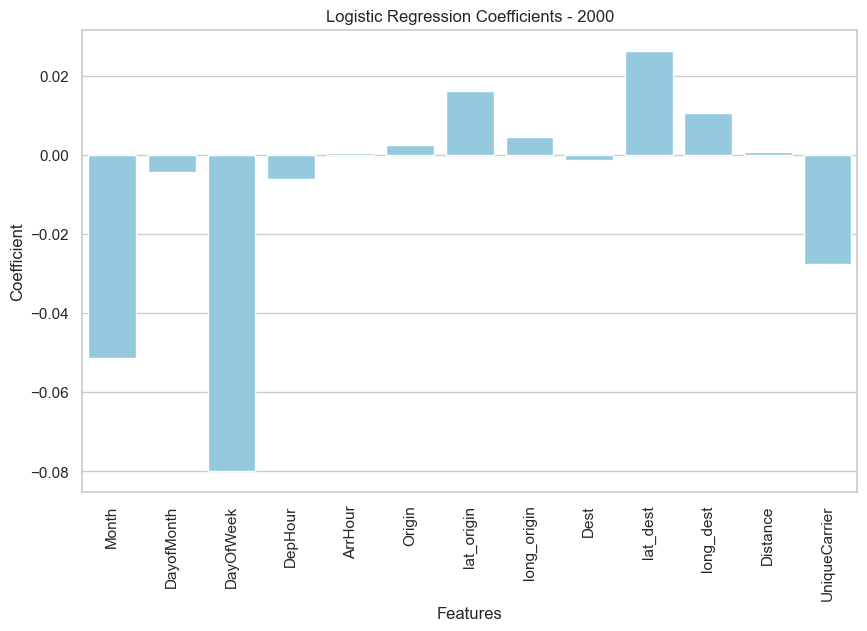

Year: 2001, Accuracy: 0.6082
Confusion Matrix for 2001:
[[724578 466396]
 [  1241   1341]]


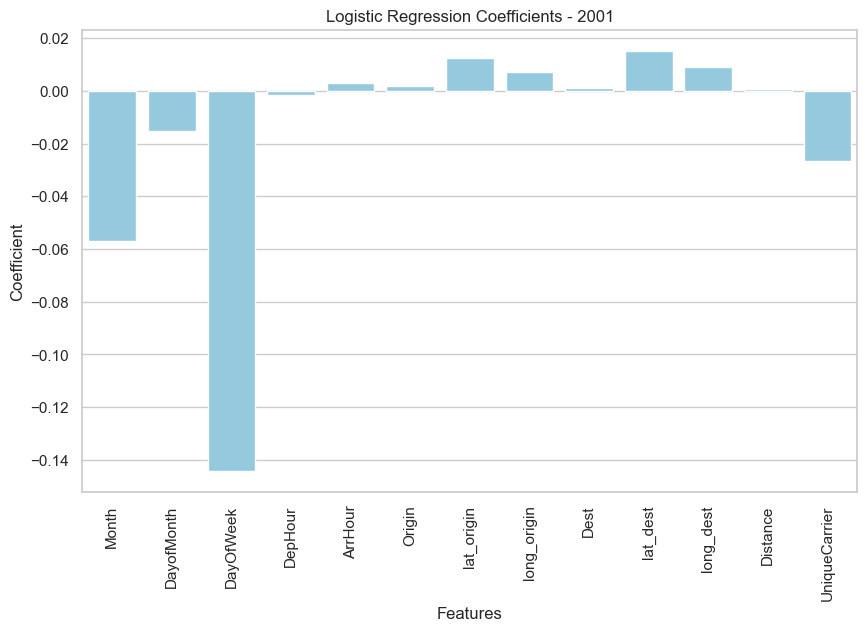

Year: 2002, Accuracy: 0.6118
Confusion Matrix for 2002:
[[644139 408462]
 [   784    887]]


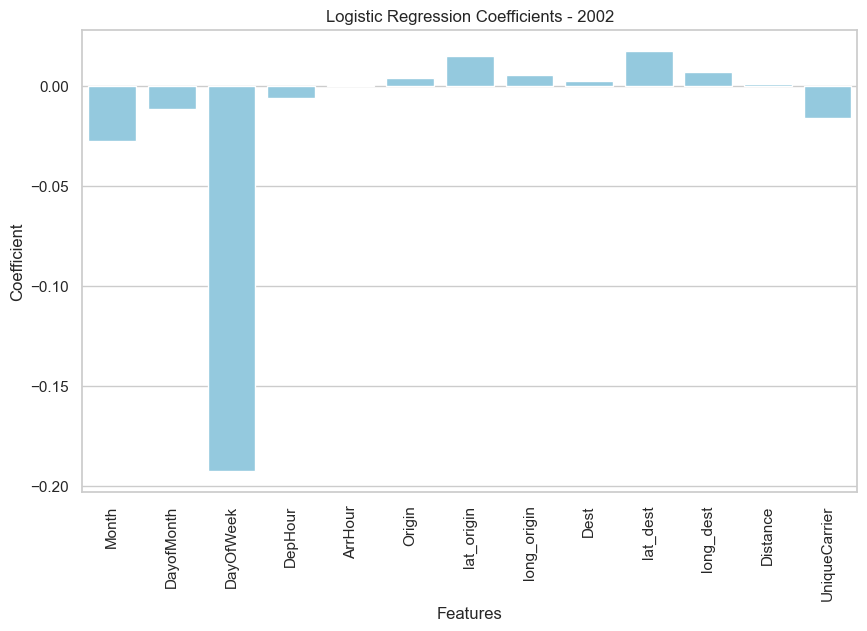

C:\Users\norma\AppData\Local\Temp\ipykernel_2288\1310464620.py:18: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  ontime = pd.read_csv(filename, encoding='utf-8')


Year: 2003, Accuracy: 0.6216
Confusion Matrix for 2003:
[[805379 490053]
 [  1058   1218]]


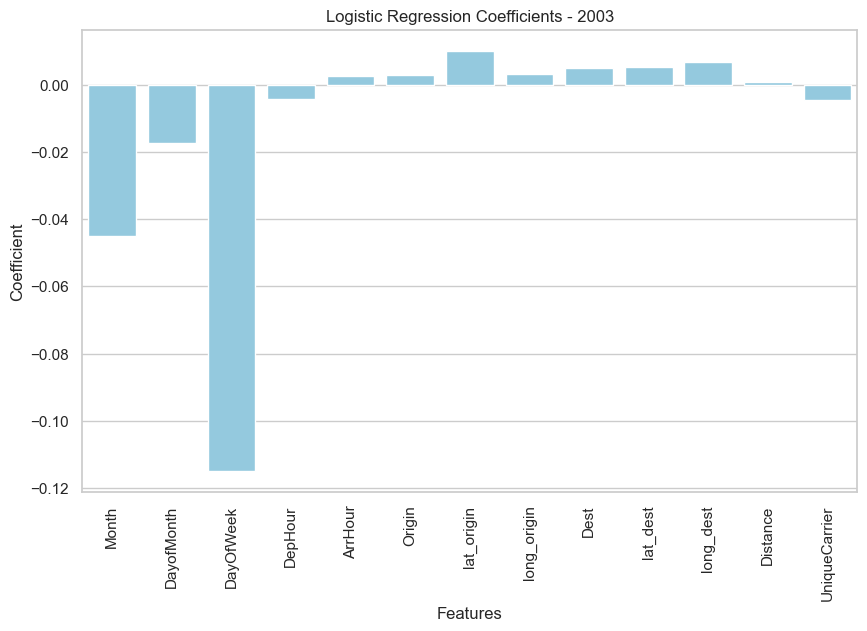

Year: 2004, Accuracy: 0.6210
Confusion Matrix for 2004:
[[884042 539055]
 [  1347   1410]]


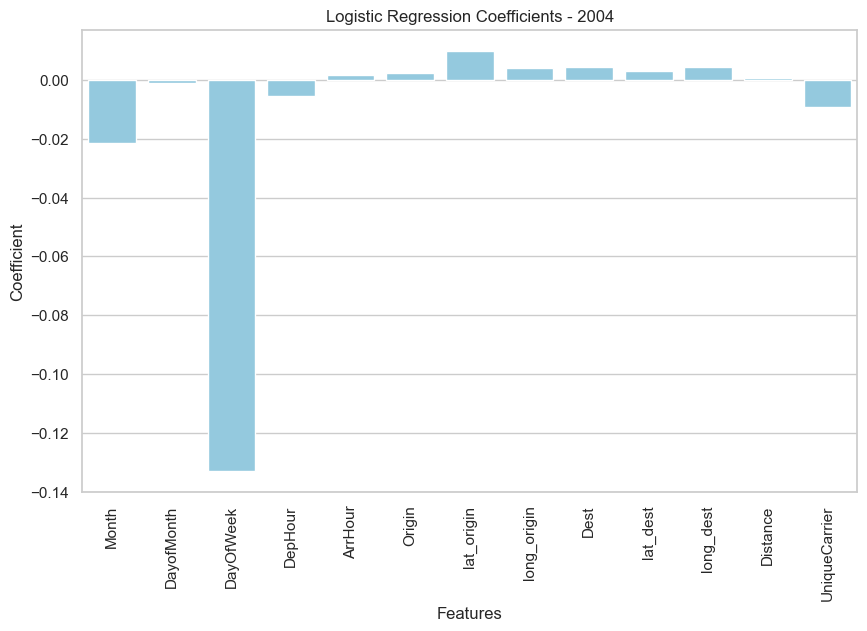

In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Initialize an empty list to store plots for Part 2c
plot_list_2c = []

for year in range(2000, 2005):
    filename = f"{year}.csv.bz2"
    
    # Load data with better encoding handling
    try:
        ontime = pd.read_csv(filename, encoding='utf-8')
    except UnicodeDecodeError:
        ontime = pd.read_csv(filename, encoding='latin-1')

    # Merge with airports data
    ontime = pd.merge(ontime, airports, left_on='Origin', right_on='iata', how='left')
    ontime = pd.merge(ontime, airports, left_on='Dest', right_on='iata', suffixes=('_origin', '_dest'), how='left')

    # Handle missing values in lat/long
    ontime[['lat_origin', 'long_origin', 'lat_dest', 'long_dest']] = ontime[
        ['lat_origin', 'long_origin', 'lat_dest', 'long_dest']
    ].fillna(0)

    # Convert categorical variables to numeric
    ontime['Origin'] = pd.factorize(ontime['Origin'])[0]
    ontime['Dest'] = pd.factorize(ontime['Dest'])[0]
    ontime['UniqueCarrier'] = pd.factorize(ontime['UniqueCarrier'])[0]

    # Convert CRSDepTime and CRSArrTime safely
    ontime['DepHour'] = ontime['CRSDepTime'].astype(str).str[:2].fillna("0").astype(int)
    ontime['ArrHour'] = ontime['CRSArrTime'].astype(str).str[:2].fillna("0").astype(int)

    # Select features and target
    features = ontime[['Month', 'DayofMonth', 'DayOfWeek', 'DepHour', 'ArrHour', 
                       'Origin', 'lat_origin', 'long_origin', 'Dest', 'lat_dest', 
                       'long_dest', 'Distance', 'UniqueCarrier']]
    target = ontime['Diverted']

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=100, stratify=target)

    # Apply SMOTE to balance data
    smote = SMOTE(random_state=100)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Fit logistic regression model with balanced class weight
    model = LogisticRegression(max_iter=1000, class_weight='balanced')
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Create confusion matrix and evaluate accuracy
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Year: {year}, Accuracy: {accuracy:.4f}")
    print(f"Confusion Matrix for {year}:\n{conf_matrix}")

    # Plot coefficients for logistic regression
    coef_df = pd.DataFrame({'variable': features.columns, 'coefficient': model.coef_[0]})

    # Plot coefficients
    plt.figure(figsize=(10,6))
    sns.barplot(x='variable', y='coefficient', data=coef_df, color='skyblue')
    plt.xticks(rotation=90)
    plt.title(f"Logistic Regression Coefficients - {year}")
    plt.xlabel('Features')
    plt.ylabel('Coefficient')
    plt.show()

